In [2]:
# General imports
import numpy as np
import re
import sympy as sp
import json

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize, differential_evolution, basinhopping

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

In [3]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=np.complex128)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix

In [12]:
cut_off = 2
q = create_matrix(cut_off, 'q')
p = create_matrix(cut_off, 'p')

Z = np.array([[1, 0], [0, -1]])  # Pauli Z matrix for fermion number
I_f = np.eye(2)  # Identity matrix for fermion space
I_b = np.eye(cut_off)

H_b = 0.5 *(np.matmul(q,q) + np.matmul(p,p))
H_b = np.kron(I_f, H_b)

H_f = 0.5*(np.kron(Z, I_b))
H = H_b + H_f
H[np.abs(H) < 10e-10] = 0

In [13]:
sympy_matrix = sp.Matrix(H)
sp.pprint(sympy_matrix, use_unicode=True)

⎡1.0   0   0  0⎤
⎢              ⎥
⎢ 0   1.0  0  0⎥
⎢              ⎥
⎢ 0    0   0  0⎥
⎢              ⎥
⎣ 0    0   0  0⎦


In [77]:
hamiltonian = SparsePauliOp.from_operator(H)
#hamiltonian = SparsePauliOp.from_list([('III',2), ('IIZ',0.5), ('IZI', -1), ('ZZI',-0.5)])
#ansatz = EfficientSU2(hamiltonian.num_qubits)
#ansatz = TwoLocal(hamiltonian.num_qubits, ['ry', 'rz'], 'cx', reps=3, entanglement='full')
ansatz = RealAmplitudes(num_qubits=hamiltonian.num_qubits, reps=1)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

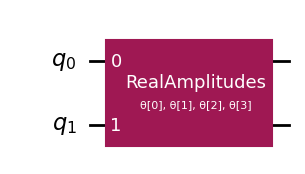

In [78]:
ansatz.draw('mpl')

In [79]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [80]:
num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [14]:
minima = []

def callback(x, f, accept):
    info = [x,f,accept]
    minima.append(info)
    return

In [81]:
energies = []
x_values = []

for i in range(100):

    print("####################")
    print(f"Session loop {i}")

    with Session(backend=aer_sim) as session:
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 10000
        #estimator.options.optimization_level = 1

        res = basinhopping(
            cost_func,
            x0,
            minimizer_kwargs={'method': "COBYLA",
                            "args": (ansatz_isa, hamiltonian_isa, estimator),
                            "options": {'maxiter':1000}},
                            #"tol": '0.00001'},
            niter = 10,
            T = 0.25,
            callback=callback
        )
        energies.append(res.fun)
        x_values.append(res.x)

####################
Session loop 0
Iters. done: 1 [Current cost: 0.6454]
Iters. done: 2 [Current cost: 0.6383999999999999]
Iters. done: 3 [Current cost: 0.17909999999999998]
Iters. done: 4 [Current cost: 0.1805]
Iters. done: 5 [Current cost: 0.6397999999999999]
Iters. done: 6 [Current cost: 0.07229999999999998]
Iters. done: 7 [Current cost: 0.1558]
Iters. done: 8 [Current cost: 0.08800000000000002]
Iters. done: 9 [Current cost: 0.48469999999999996]
Iters. done: 10 [Current cost: 0.24430000000000002]
Iters. done: 11 [Current cost: 0.07450000000000001]
Iters. done: 12 [Current cost: 0.10670000000000002]
Iters. done: 13 [Current cost: 0.010799999999999976]
Iters. done: 14 [Current cost: 0.008599999999999997]
Iters. done: 15 [Current cost: 0.007900000000000018]
Iters. done: 16 [Current cost: 0.0028000000000000247]
Iters. done: 17 [Current cost: 0.005300000000000027]
Iters. done: 18 [Current cost: 0.00940000000000002]
Iters. done: 19 [Current cost: 0.0010000000000000009]
Iters. done: 20 [C

In [73]:
res

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.0010999999999996568
                          x: [ 3.127e+00  6.159e+00 -1.640e+00  4.679e+00
                               3.138e+00  3.031e+00  4.637e+00  4.783e+00]
                        nit: 10
      minimization_failures: 0
                       nfev: 1033
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.0010999999999996568
                                   x: [ 3.127e+00  6.159e+00 -1.640e+00
                                        4.679e+00  3.138e+00  3.031e+00
                                        4.637e+00  4.783e+00]
                                nfev: 88
                               maxcv: 0.0

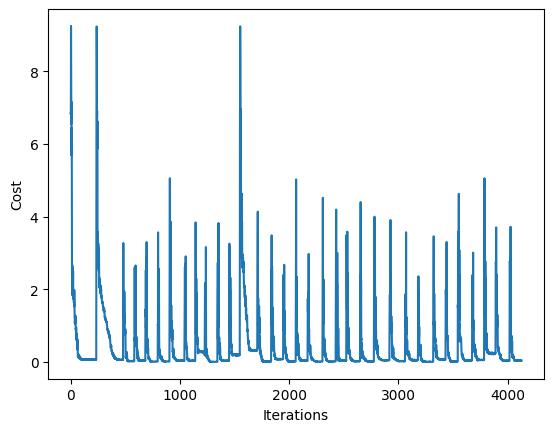

In [20]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [109]:
run = {
    'potential': 'QHO',
    'cutoff': 8,
    'ansatz': 'RealAmplitudes',
    'num_sessions': 100,
    'backend': 'aer_simulator',
    'estimator_shots': 10000,
    'min_function': {'name': 'basinhopping',
                     'args': {'minimizer_kwargs': {'method': "COBYLA",
                                                    "args": ('ansatz_isa', 'hamiltonian_isa', 'estimator'),
                                                    "options": {'maxiter':1000}},   
                                'niter': 10,
                                'T': 0.25}
                    },
    'results': energies,
    'x_values': [x.tolist() for x in x_values]
}

In [110]:
path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Files\QHO\QHO_2.json"

In [94]:
# Save the variable to a JSON file
with open(path, 'w') as json_file:
    json.dump(run, json_file, indent=4)

In [14]:
n_values = [2, 4, 8, 16]
data_dict = {}

base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Files\QHO\QHO_{}.json"

for n in n_values:
    file_path = base_path.format(n)
    with open(file_path, 'r') as json_file:
        data_dict[f'c{n}'] = json.load(json_file)

In [15]:
for c in data_dict.keys():
    res = [abs(x) for x in data_dict[c]['results']]
    print(c)
    print("Min: ", min(res))
    print("Avg: ", np.mean(res))

c2
Min:  0.0
Avg:  5.000000000000005e-06
c4
Min:  2.220446049250313e-16
Avg:  0.00027700000000020764
c8
Min:  1.1102230246251565e-16
Avg:  0.0019649999999996914
c16
Min:  0.0009999999999998899
Avg:  0.006961000000000062
